In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive

/content/gdrive


In [ ]:
nat_path = 'My Drive/Machine Learning/errors study/github/'

In [ ]:
# Imports

import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import multiprocessing as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler

import keras.backend as K
from keras import optimizers, models
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# CNN Functions

In [ ]:
class cnn_functions:

  """
  - Learning Curves
  - Reshape input and target values as tensors
  - Plot ROC curves and Confusion Matrices
  - Generate report.txt
  """

  def plot_learn_curves(history, time, title, save=False):
      fig, axs = plt.subplots(1, 2, figsize=(12, 4))
      
      # Accuracy
      axs[0].plot(history.history['accuracy'], linestyle='dashed')
      axs[0].plot(history.history['val_accuracy'], linestyle='dashed')
      axs[0].legend(['Train', 'Valid'], loc='upper left')
      axs[0].set_title('Accuracy')
        
      # Loss
      axs[1].plot(history.history['loss'], linestyle='dashed')
      axs[1].plot(history.history['val_loss'], linestyle='dashed')
      axs[1].legend(['Train', 'Valid'], loc='upper left')
      axs[1].set_title('Loss')
      
      fig.text(0.52, 0.02, 'Epoch', fontsize=14, ha='center', va='center')
      fig.text(0.22, 0.02, 'Elapsed %.3f seconds.' % time, fontsize=10, ha='center', va='center')
      fig.suptitle(title, y=0.97, fontsize=14, ha='center', va='center')

      if save:
        fig.savefig(dir_name + 'learning_curves.png')

      plt.show()


################################################################################

  def plot_roc_cm(y_true, probs, dir_name, save=False):
    
      y_pred = pd.DataFrame(probs).idxmax(axis=1)

      fig, ax = plt.subplots(1, 2, figsize=(10, 4))


      ########## ROC curves

      fpr, tpr, thresholds = roc_curve(y_true, probs[:, 1])
      auc = roc_auc_score(y_true, probs[:, 1])
        
      ax[0].plot([0, 1], [0, 1], 'k--')
      ax[0].plot(fpr, tpr, label="AUC: %.3f" % auc, color='C1', linewidth=3)
      ax[0].legend(loc='best')
      ax[0].set_title('ROC Curve', fontsize=12)
      ax[0].set_xlabel('False Positive Rate', fontsize=12)
      ax[0].set_ylabel('True Positive Rate', fontsize=12)


      ########## Confusion Matrix
      
      # Only use the labels that appear in the data
      classes = unique_labels(y_true, y_pred)
      
      # Choose color
      cmap = plt.cm.GnBu  
        
      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
      norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      fmt = 'd'
      norm_fmt = '.3f'
          
      im = ax[1].imshow(norm_cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
      ax[1].figure.colorbar(im, ax=ax[1])
      
      # We want to show all ticks...
      ax[1].set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             xticklabels=['Frowny', 'Smiley'],
             yticklabels=['Frowny', 'Smiley'])
      
      ax[1].set_title('Confusion Matrix', fontsize=12)
      ax[1].set_ylabel('True Label', fontsize=12)
      ax[1].set_xlabel('Predicted Label', fontsize=12)

      # Loop over data dimensions and create text annotations.
      thresh = 0.65
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax[1].text(j, i, format(norm_cm[i, j], norm_fmt),
                      ha="center", va="baseline",
                      color="white" if norm_cm[i, j] > thresh else "black",
                      fontsize=12)
              ax[1].text(j, i, '\n\n\n' +
                      format(cm[i, j], fmt) + '/' +
                      format(np.sum(cm[i, :]), fmt),
                      ha="center", va="center",
                      color="white" if norm_cm[i, j] > thresh else "black",
                      fontsize=10)


      acc = accuracy_score(y_true, y_pred)

      fig.suptitle('Accuracy = {}\n'.format(acc), y=0.95, fontsize=16)        
      fig.tight_layout(rect=[0, 0.03, 1, 0.95])

      if save:
        fig.savefig(dir_name + 'scores.png')

      plt.show()

################################################################################

  def report(report_comments):

    """
    Report the model in a .txt document
    - report_comments: general, additional comments - list with string
    """

    # Create txt report of the model
    txt = open(dir_name + 'report.txt', 'w+')

    txt.write('Date: {}'.format(date.today()))

    txt.write('\n\nModel: CNN1D {}'.format(cnn_name))
    txt.write('\n\nTraining time elapsed: {}'.format(elapsed_train))

    txt.write('\n\nComments: {}'.format(report_comments))

    txt.write('\n\n### Model settings')
    txt.write('\nCompile Parameters: {}'.format(cnn_model_settings.compile_params))
    txt.write('\n#Callbacks Parameters')
    txt.write('\nEarly Stopping: {}'.format(cnn_model_settings.earlystop_params))
    txt.write('\nReduce LR on Plateau: {}'.format(cnn_model_settings.reduceLR_params))

    txt.write('\n\n### Validation settings')
    txt.write('\nValidation Split Parameters: {}'.format(data_preprocess.val_params))

    txt.close()

################################################################################

# Data Preprocessing Functions

In [ ]:
class data_preprocess:

  val_params = {'test_size': 0.2,
                'random_state': 42,
                'shuffle': True}

  def train_val_set(X, y, validation_params=None):

        """
        Split training set into train and validation.
        Set the parameters in the dictionary 'val_params' above.
        Return train and validation sets with the proper shape.

        """

        if validation_params == None:
          validation_params = data_preprocess.val_params
      
        
        # Validation Set
        xtrain, xval, ytrain, yval = train_test_split(X, y, stratify=y,
                                                      **validation_params)

        train_set = [xtrain, ytrain]
        val_set = [xval, yval]
            
        data = [train_set, val_set]
            
        return data


  def set_shape_cnn1D(data, n, cnn_name):

    if cnn_name == 'no_err':
      X = data[:, :n]
    
    elif cnn_name == 'with_err':
      X = data[:, :n*2]

    elif cnn_name == 'stack_err':
      X = data[:, :n*2]

      med = np.array(X[:, :n])  # measurement
      err = np.array(X[:, n:])  # uncertainty

      X = np.stack([med, err], axis=2)

    return X


  def prepare_data(train, n, cnn_name, validation_params=None):
    """
    Select features, reshape data tensor and run the procedures above.
    """

    ytrain = np.array(train['type'])
    xtrain = np.array(train.drop(columns=['type']))

    xtrain = data_preprocess.set_shape_cnn1D(xtrain, n, cnn_name)


    ytrain = np_utils.to_categorical(ytrain, num_classes=2)
    if cnn_name != 'stack_err':
      xtrain = xtrain.reshape(xtrain.shape[0],
                              xtrain.shape[1], 1).astype('float32')

    # Split into train and validation
    train_set, val_set = data_preprocess.train_val_set(xtrain, ytrain,
                                                       validation_params)
    
    data = [train_set, val_set]

    return data

# Train

## Load data and set file path

In [ ]:
# Load training set
#train = pd.read_csv(nat_path + 'datasets/gauss/vary_sig0/train_m200_n20_sig16_dg5.csv')
train = pd.read_csv(nat_path + 'train.csv')
# Number of features
n = 20

# CNN1D type: no_err, stack_err or with_err
cnn_name = 'no_err'

In [ ]:
# Set path to a directory to save the model
study_case = 'check'

In [ ]:
dir_name = nat_path + '{}/{}/'.format(cnn_name, study_case)

# Create folder
if os.path.exists(dir_name):
  print('ignoring: FILE EXISTS!')
else:
  os.mkdir(path=dir_name)

ignoring: FILE EXISTS!


## Prepare Data

In [ ]:
data = data_preprocess.prepare_data(train, n, cnn_name)

## Build model

In [ ]:
class cnn_model_settings:

  compile_params = {'loss': 'binary_crossentropy',
                    'optimizer': 'Adam',
                    'metrics': ['accuracy'],
                    'loss_weights': None,
                    'sample_weight_mode': None, 
                    'weighted_metrics': None, 
                    'target_tensors': None}


  def create_model():

    if cnn_name == 'stack_err':
      n_channels = 2
    else:
      n_channels = 1

    if cnn_name == 'with_err':
      length = 2 * n
    else:
      length = n

    model = Sequential()
    
    model.add(Conv1D(32, (5,), input_shape=(length, n_channels), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D((2,), strides=(2,)))
    
    model.add(Conv1D(64, (3,), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D((2,), strides=(2,)))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(64, (3,), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D((2,), strides=(2,)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(**cnn_model_settings.compile_params)
    model.summary()

    
    return model

  
  reduceLR_params = {'monitor': 'val_loss',
                     'factor': 0.1,
                     'patience': 10,
                     'verbose': 1,
                     'mode': 'min',
                     'min_delta': 0.0001,
                     'cooldown': 0,
                     'min_lr': 0}

  earlystop_params = {'monitor': 'val_loss',
                      'patience': 16,
                      'min_delta': 0.0001,
                      'verbose': 1,
                      'mode': 'auto',
                      'baseline': None,
                      'restore_best_weights': False}

  logger_params = {'filename': dir_name + 'epochs_results.csv',
                   'separator': ',',
                   'append': False}

  checkpoint_params = {'filepath': dir_name + 'best_acc.h5',
                       'monitor': 'val_accuracy',
                       'mode': 'max',
                       'verbose': 0,
                       'save_best_only': True,
                       'save_weights_only': False,
                       'save_freq': 'epoch'}


  def get_callbacks():

    early_stop = EarlyStopping(**cnn_model_settings.earlystop_params)
    reduce_lr_loss = ReduceLROnPlateau(**cnn_model_settings.reduceLR_params)
    csv_logger = CSVLogger(**cnn_model_settings.logger_params)
    mcp_save = ModelCheckpoint(**cnn_model_settings.checkpoint_params)
    
    return [early_stop, reduce_lr_loss, csv_logger, mcp_save]


  def run_cnn(info):
  
    data, model = info
    
    train, val = data
    
    xtrain, ytrain = train
    xval, yval = val
    
    batch_size = 100

    callbacks = cnn_model_settings.get_callbacks()

    start = time.perf_counter()

    history = model.fit(xtrain, ytrain,
                        batch_size=batch_size,
                        epochs=500,
                        verbose=1,
                        validation_data=(xval, yval),
                        callbacks=callbacks)

    elapsed = time.perf_counter() - start
    print('Elapsed %.3f seconds.' % elapsed)
    
    return history, elapsed

In [ ]:
model = cnn_model_settings.create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            192       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0

## Run model

In [ ]:
info = [data, model]
hist, elapsed_train = cnn_model_settings.run_cnn(info)

Epoch 1/500
1600/1600 [==============================] - 40s 13ms/step - loss: 0.4762 - accuracy: 0.7688 - val_loss: 0.4221 - val_accuracy: 0.8060
Epoch 2/500
1600/1600 [==============================] - 21s 13ms/step - loss: 0.3813 - accuracy: 0.8305 - val_loss: 0.3673 - val_accuracy: 0.8332
Epoch 3/500
1600/1600 [==============================] - 20s 13ms/step - loss: 0.3672 - accuracy: 0.8376 - val_loss: 0.3586 - val_accuracy: 0.8433
Epoch 4/500
1600/1600 [==============================] - 20s 13ms/step - loss: 0.3625 - accuracy: 0.8401 - val_loss: 0.3553 - val_accuracy: 0.8412
Epoch 5/500
1600/1600 [==============================] - 21s 13ms/step - loss: 0.3557 - accuracy: 0.8421 - val_loss: 0.4008 - val_accuracy: 0.8180
Epoch 6/500
1600/1600 [==============================] - 20s 13ms/step - loss: 0.3539 - accuracy: 0.8448 - val_loss: 0.3762 - val_accuracy: 0.8323
Epoch 7/500
1600/1600 [==============================] - 21s 13ms/step - loss: 0.3487 - accuracy: 0.8480 - val_loss: 0

## Report model

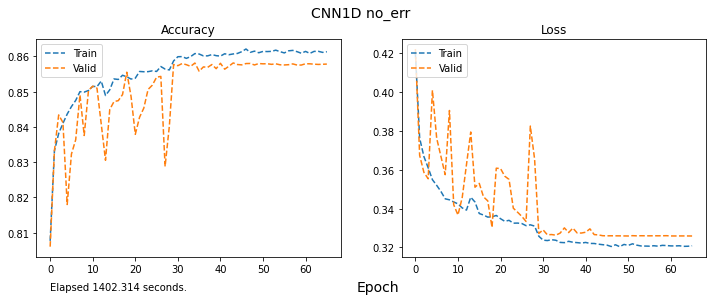

In [ ]:
report_comments = ['smiley-frowny, sigma0 = 0.5, delta g = 0.5.']

cnn_functions.plot_learn_curves(hist, elapsed_train,
                                title='CNN1D ' + cnn_name, save=True)

cnn_functions.report(report_comments)

## Apply model: validation set

In [ ]:
model = load_model(dir_name + 'best_acc.h5')

In [ ]:
xval, yval = data[1]
yval = pd.DataFrame(yval).idxmax(axis=1).reset_index(drop=True)

In [ ]:
probs_val = model.predict(xval)

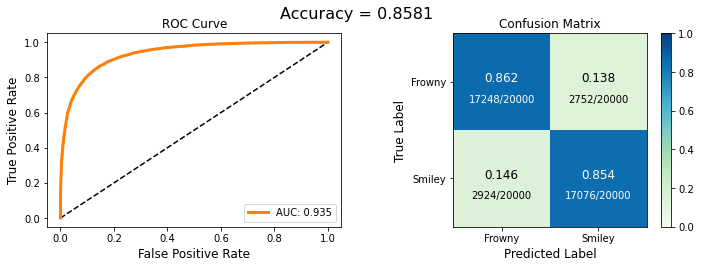

In [ ]:
cnn_functions.plot_roc_cm(yval, probs_val, dir_name, save=False)

# Apply model: test set

In [ ]:
# CNN1D type: no_err, stack_err or with_err
cnn_name = 'no_err'

# Save predictions?
save = False
dir_name = nat_path + cnn_name + '/check/'

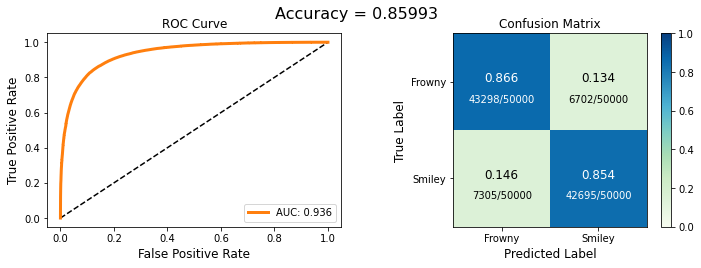

In [ ]:
# Load testing set
test = pd.read_csv(nat_path + 'datasets/gauss/vary_sig0/test_m100_n20_sig16_dg5.csv')

n = 20

model = load_model(dir_name + 'best_acc.h5')

ytest = test['type']
xtest = test.drop(columns=['type'])

xtest = data_preprocess.set_shape_cnn1D(xtest.to_numpy(), n, cnn_name)

if cnn_name != 'stack_err':
  xtest = xtest.reshape(xtest.shape[0],
                        xtest.shape[1], 1).astype('float32')

probs = model.predict(xtest)

cnn_functions.plot_roc_cm(ytest, probs, dir_name, save=save)
if save:
  pd.DataFrame(probs).to_csv(dir_name + 'probs.csv', index=False)